In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

### Login huggingface hub

In [2]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()
login(os.getenv('HUGGINGFACE_TOKEN'))

/Users/daniele/KTH-Projects/ID2223-Project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/daniele/.cache/huggingface/token
Login successful


### Downlaod dataset

In [3]:
from datasets import load_dataset

DATASET_RAW = "hugginglearners/data-science-job-salaries"

dataset = load_dataset(DATASET_RAW, split="train")

In [4]:
import pandas as pd

dataset = pd.DataFrame(dataset).drop(columns=['Unnamed: 0'])
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:
dataset.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,6.070000e+02,607.000000,607.00000
mean,2021.405272,3.240001e+05,112297.869852,70.92257
std,0.692133,1.544357e+06,70957.259411,40.70913
min,2020.000000,4.000000e+03,2859.000000,0.00000
25%,2021.000000,7.000000e+04,62726.000000,50.00000
50%,2022.000000,1.150000e+05,101570.000000,100.00000
75%,2022.000000,1.650000e+05,150000.000000,100.00000
max,2022.000000,3.040000e+07,600000.000000,100.00000


# Feature engineering

We will use only the salary in USD dollars, so we will drop the other column. Also, we will drop **employee_residence** and **remote_ratio** to reduce the number of useless features.

In [6]:
dataset['salary'] = dataset['salary_in_usd']
dataset.drop(columns=['salary_in_usd','employee_residence','salary_currency', 'remote_ratio'], inplace=True)

In [7]:
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,L


### Experience level

We will map the experience level to a number, so we can use it in the model.

In [8]:
dataset['experience_level'].value_counts()

experience_level
SE    280
MI    213
EN     88
EX     26
Name: count, dtype: int64

In [9]:
experience_level_map = {
    'EN': 0,
    'MI': 1,
    'SE': 2,
    'EX': 3
}

dataset['experience_level'] = dataset['experience_level'].map(experience_level_map)
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,company_location,company_size
0,2020,1,FT,Data Scientist,79833,DE,L
1,2020,2,FT,Machine Learning Scientist,260000,JP,S
2,2020,2,FT,Big Data Engineer,109024,GB,M
3,2020,1,FT,Product Data Analyst,20000,HN,S
4,2020,2,FT,Machine Learning Engineer,150000,US,L


<Axes: xlabel='job_title'>

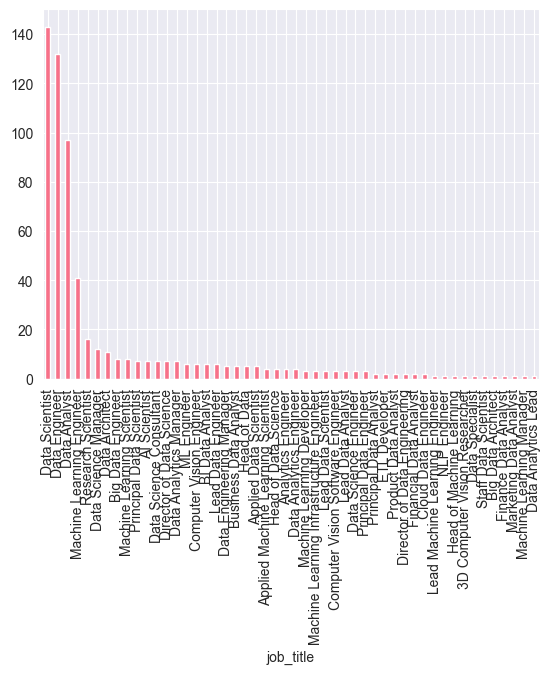

In [10]:
dataset['job_title'].value_counts().plot.bar()

#### Employment type

In [11]:
dataset['employment_type'].value_counts()

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

We will use only the full time jobs, so we will drop the other rows. And so drop the column.

In [12]:
dataset = dataset[dataset['employment_type'] == 'FT'].drop(columns=['employment_type'])
dataset.head()

,work_year,experience_level,job_title,salary,company_location,company_size
0,2020,1,Data Scientist,79833,DE,L
1,2020,2,Machine Learning Scientist,260000,JP,S
2,2020,2,Big Data Engineer,109024,GB,M
3,2020,1,Product Data Analyst,20000,HN,S
4,2020,2,Machine Learning Engineer,150000,US,L


### Company location

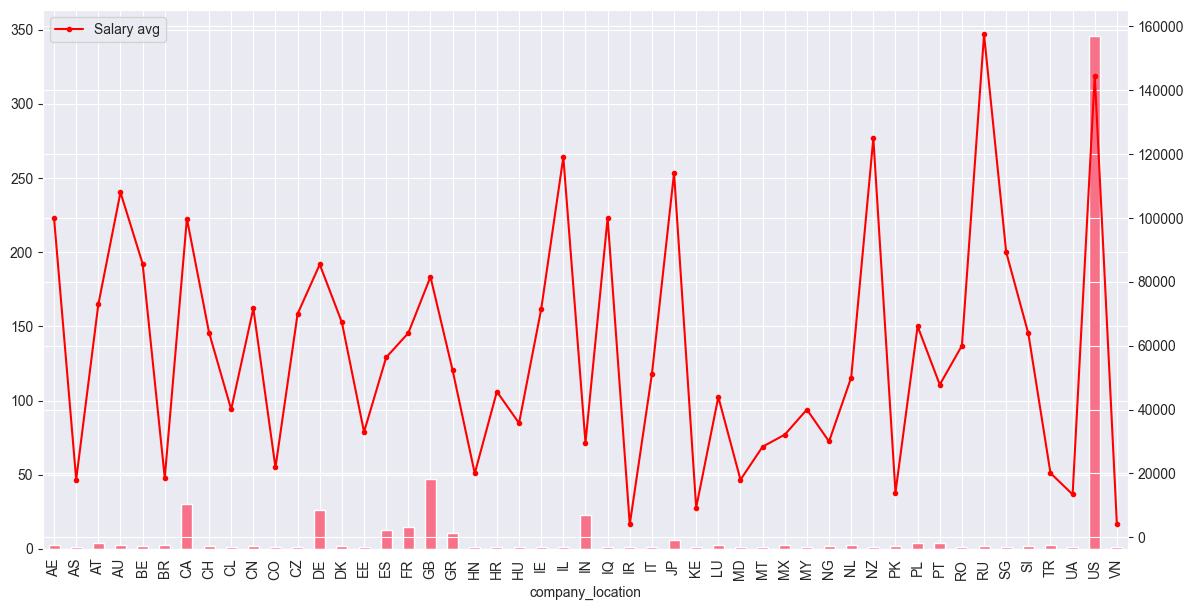

In [13]:
salary_avg = dataset.groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})

ax = dataset['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)
ax2.legend(['Salary avg'], loc='upper left')

#### CPI (Consumer Price Index)
The consumer price index (CPI) measures the average price change of all goods and services purchased by households for consumption purposes, e.g. food, clothing, motor vehicles, rents, cleaning services, repairs, etc.

> Note. The CPI used is the current CPI, not the CPI adjusted the yera of the salary. This for a technical reason: the CPI is not available for all the years, so we will use the current CPI for all the salaries.

In [48]:
import requests

def get_cpi_by_country_code(country_code, index='FP.CPI.TOTL'):
    # World Bank API endpoint for CPI data
    api_url = f'http://api.worldbank.org/v2/country/{country_code}/indicator/{index}?format=json'

    # Make a GET request to the API
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract the most recent CPI value from the response
        cpi_value = data[1][0]['value'] if data[1] else None

        return cpi_value
    else:
        # If the request was not successful, print an error message
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return None

In [32]:
import pycountry_convert as pc
from tqdm import tqdm

country_CPI = dataset['company_location'].unique()
CPI_values = []
with tqdm(country_CPI) as pbar:
    for c in pbar:
        val = get_cpi_by_country_code(c)
        CPI_values.append(val)
        pbar.postfix = f'CPI: {val} of {c}'


country_CPI = pd.DataFrame({'company_location': country_CPI, 'CPI': CPI_values})
country_CPI.head()

100%|██████████| 41/41 [00:11<00:00,  3.70it/s, CPI: 117.221883969731 of IE]


,company_location,CPI
0,DE,124.489744
1,JP,107.839691
2,GB,133.660070
3,HN,177.302656
4,US,134.211206


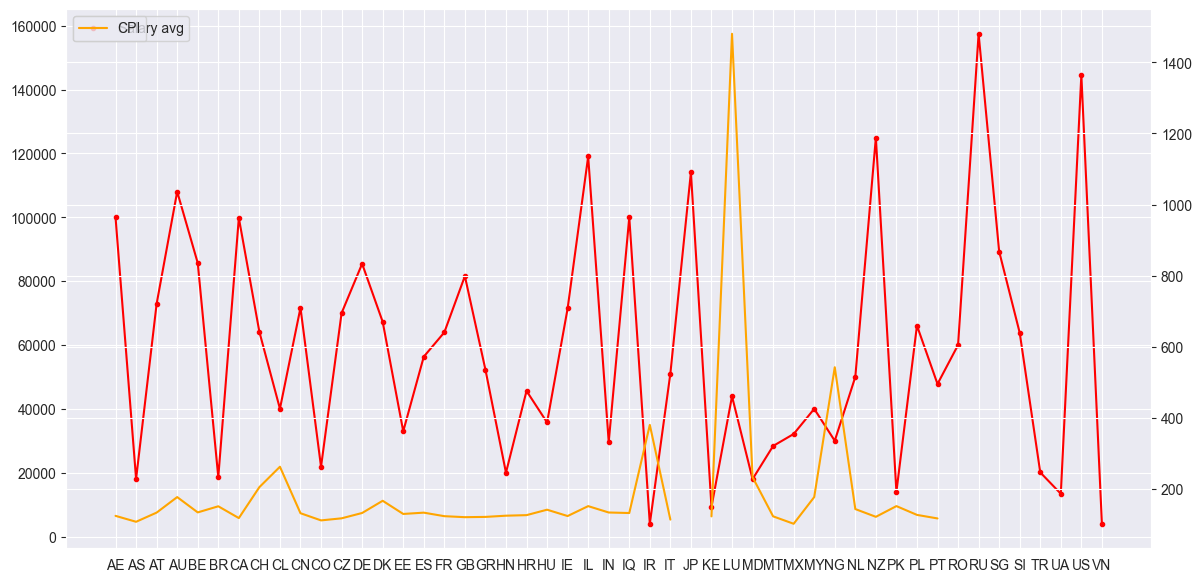

In [33]:
ax = plt.figure(figsize=(14, 7)).gca()

ax.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)

ax.legend(['Salary avg'], loc='upper left')

ax3 = ax.twinx()
ax3.plot(country_CPI['CPI'], color='orange')
ax3.legend(['CPI'], loc='upper left')

#### Check if make sense to group by continent

In [34]:
dataset['company_continent'] = dataset['company_location'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

<Axes: xlabel='company_continent'>

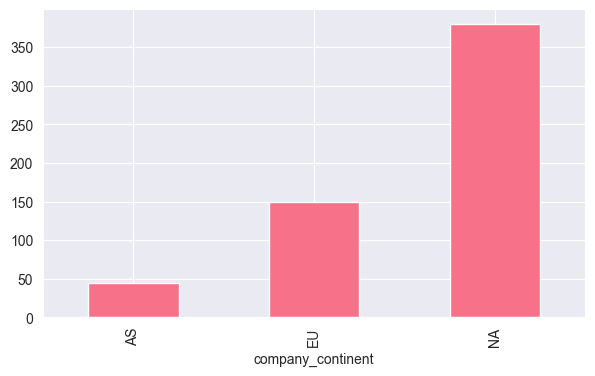

In [35]:
dataset['company_continent'].value_counts().sort_index().plot.bar( figsize=(7,4))

We can see that the majority of the companies are in EU, NA and AS. So we will exclude the other continents, since we don't have enough data.

In [36]:
dataset = dataset[dataset['company_continent'].isin(['EU', 'NA', 'AS'])]

### Salary avg inside europe

In [37]:
salary_avg_europe = dataset.where(dataset['company_continent'] == 'EU').groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
salary_avg_europe.describe()

,salary_avg
count,25.000000
mean,59417.044826
std,28083.659521
min,13400.000000
25%,45618.000000
50%,60000.000000
75%,69999.000000
max,157500.000000


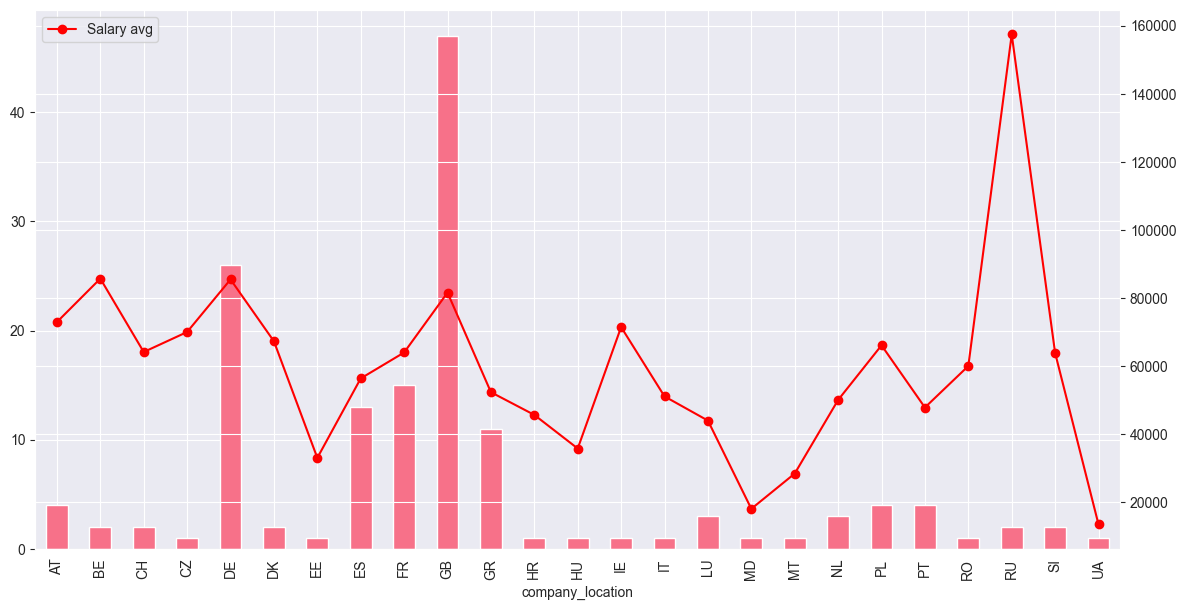

In [38]:
ax = dataset.where(dataset['company_continent'] == 'EU')['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg_europe['salary_avg'], color='r', marker='o')
ax2.legend(['Salary avg'], loc='upper left')

### Correlation between salary and CPI in europe

In [39]:
salary_avg_europe_se = dataset.where(dataset['company_continent'] == 'EU')\
                              .where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_europe_se)

45

In [40]:
salary_avg_europe_se['CPI']= salary_avg_europe_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_europe_se.notnull().sum()

company_location    45
experience_level    45
salary_avg          45
CPI                 45
dtype: int64

In [41]:
#calculate the correlation coefficient with CPI
from scipy.stats import pearsonr
results =[]
for exp in salary_avg_europe_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['CPI'], salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].count()
    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,-0.487327,6.021470e+08,20,0.029300
1,2.0,0.265942,4.863888e+08,13,0.379823
2,0.0,-0.366862,4.241498e+08,9,0.331462
3,3.0,0.705583,1.712607e+09,3,0.501371


#### Correlation between salary and CPI worldwide

In [42]:
salary_avg_se = dataset.where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_se)

77

In [43]:
salary_avg_se['CPI']= salary_avg_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_se.notnull().sum()

company_location    77
experience_level    77
salary_avg          77
CPI                 77
dtype: int64

In [44]:
#calculate the correlation coefficient with CPI

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['CPI'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,-0.393880,1.174613e+09,33,0.023330
1,2.0,-0.415712,1.838335e+09,20,0.068313
2,0.0,-0.376072,9.378856e+08,18,0.124024
3,3.0,-0.387013,3.397099e+09,6,0.448464


From the result above, we can see that the correlation between salary and CPI is medium, and the variance is high. Also, the correlation is negative, which means that the higher the CPI, the lower the salary. This is not what we expected!

### Correlation between salary and GDP worldwide

In [49]:
import pycountry_convert as pc
from tqdm import tqdm

country_GDP = dataset['company_location'].unique()
GDP_values = []
with tqdm(country_GDP) as pbar:
    for c in pbar:
        val = get_cpi_by_country_code(c, index='NY.GDP.MKTP.CD')
        GDP_values.append(val)
        pbar.postfix = f'GDP: {val} of {c}'


country_GDP = pd.DataFrame({'company_location': country_GDP, 'GDP': GDP_values})
country_GDP.head()

100%|██████████| 41/41 [00:11<00:00,  3.67it/s, GDP: 533140011838.276 of IE]


,company_location,GDP
0,DE,4.082469e+12
1,JP,4.232174e+12
2,GB,3.089073e+12
3,HN,3.171770e+10
4,US,2.543970e+13


In [50]:
salary_avg_se['GDP']= salary_avg_se['company_location'].apply(lambda x: country_GDP[country_GDP.company_location == x].GDP.values[0])

salary_avg_se.notnull().sum()

company_location    77
experience_level    77
salary_avg          77
CPI                 77
GDP                 77
dtype: int64

In [51]:
#calculate the correlation coefficient with GDP

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['GDP'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,0.294899,1.174613e+09,33,0.095708
1,2.0,0.483192,1.838335e+09,20,0.030912
2,0.0,0.654577,9.378856e+08,18,0.003202
3,3.0,0.764412,3.397099e+09,6,0.076715


### Job title

In [57]:
dataset['job_title'].value_counts()

job_title
Data Scientist                              136
Data Engineer                               129
Data Analyst                                 95
Machine Learning Engineer                    39
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Data Analytics Manager                        7
Machine Learning Scientist                    7
Data Science Consultant                       7
Director of Data Science                      7
Principal Data Scientist                      6
Data Engineering Manager                      5
Applied Data Scientist                        5
Head of Data                                  5
BI Data Analyst                               5
Lead Data Engineer                            5
Analytics Engineer                            4
AI Scientist                                  4
Head of Data Science          

In [58]:
# All jabs with 'Manager' in the title
dataset[dataset['job_title'].str.contains('Manager')]['job_title'].value_counts()

job_title
Data Science Manager        12
Data Analytics Manager       7
Data Engineering Manager     5
Machine Learning Manager     1
Name: count, dtype: int64